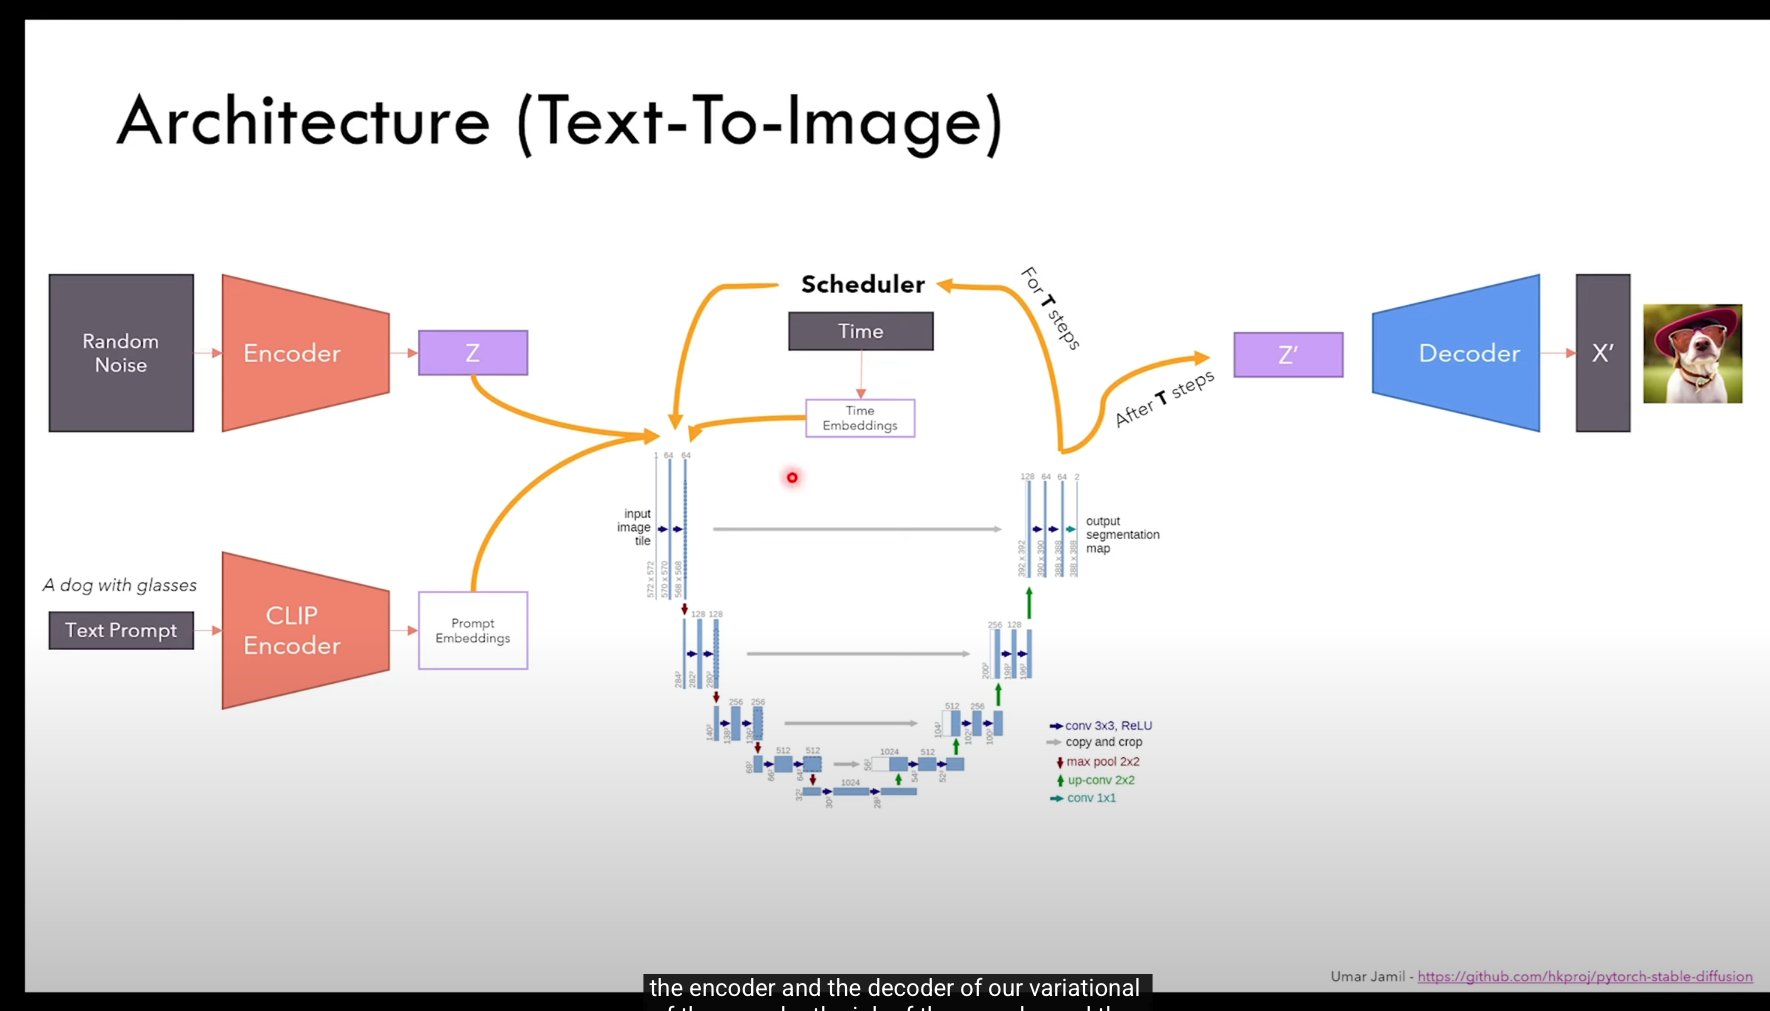



In [17]:
import torch
from torch import nn
from torch.nn import functional as F
import math

In [ ]:
# decoder 
class Vae_ResidualBlock():
    def __init__(self, in_channels , out_channels):
        super().__init__()

        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels , out_channels, kernal_size=3 , padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(in_channels , out_channels, kernal_size=3 , padding=1)

        if in_channels == out_channels:
            self.residual = nn.Identity()
        else :
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self , x: torch.Tensor) -> torch.Tensor:
        #x = (batchsize , in_channels , height , width)

        residue = x

        x = self.groupnorm_1(x)

        x = F.silu(x)

        x= self.conv_1(x)

        x= self.groupnorm_2(x)

        x= F.selu(x)

        x = self.conv_2(x)

        return x + self.residual_layer(residue)
    
    

In [ ]:
#self attention
class SelfAttention(nn.Module):

    def __init__( self , n_heads:int, d_embd: int, in_proj_bias=True , out_proj=True):
        super().__init__()

        self.in_proj = nn.Linear( d_embd, 3 * d_embd , bias= in_proj_bias)
        self.out_proj = nn.Linear(d_embd, d_embd, bias=out_proj)
        self.n_heads = n_heads
        self.d_head = d_embd // n_heads

    def forward(self, x:torch.Tensor , casual_mask= True):

        input_shape = x.shape
        batch_size , sequence_len , d_embd = input_shape

        intermediate_shape = (batch_size, sequence_len, self.n_heads , self.d_head)
        

        q,k,v = self.in_proj(x).chunk( 3, dim=-1)       #seperate projections

        q = q.view(intermediate_shape).transpose(1,2)
        k = k.view(intermediate_shape).transpose(1,2)
        v = v.view(intermediate_shape).transpose(1,2)

        wei = q @ k.T
        if casual_mask:     #upper triangular(values above principle diagonal is 1)--> which we have to fill with -infinity
            mask = torch.ones_like(wei , dtype=torch.bool).tril(1)
            wei.masked_fill_(mask, -torch.inf)

        wei = wei/math.sqrt(self.d_head)
        wei = F.softmax(wei, dim = -1)

        output = wei @ v        #we have transposed above to doing it back
        output = output.transpose(1,2)
        output = output.reshape(input_shape)
        output = self.out_proj(output)      #we have not specified the parameters of the out_projections then how? 
        return output

In [ ]:
# attention block 

class Vae_AttentionBlock(nn.Module):
    
    def __init__(self , channels: int):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32 , channels)
        self.attention = SelfAttention(1, channels)

    def forward(self, x: torch.Tensor):
        # x --> batchsize, features/channel , height , width

        residue = x

        n , c , h , w = x.shape

        x = x.view(n , c , h*w)    
        x = x.transpose(-1,-2)      #--> (n , c , h*w ) --> (n, h*w, c) , pixel corresponding to 1 channel are arranged along the column , so self attention is maybe learning the relationship between the pixel along different channel

        x = self.attention(x)

        x = x.transpose(-1, -2)     # to inverse the transformation

        x = x.view(n,c,h,w)

        x += residue

        return x
        

In [ ]:


class VAE_Encoder(nn.Sequential):

    def __init__(self,x):

        super().__init__(
            nn.Conv2d(3, 128 , kernal_size=3 , padding = 1),        #(batch_size, channel , height , width) --> (batch_size , 128 , height , width) , padding = 1 
            Vae_ResidualBlock(128, 128 ),   #(batch_size, 128 , height , width) --> (batch_size , 128 , height , width)
            Vae_ResidualBlock(128, 128),    #(batch_size, 128 , height , width) --> (batch_size , 128 , height , width)

            nn.Conv2d(3, 128 , kernal_size=3 , stride = 2, padding = 0),  
            Vae_ResidualBlock(128, 256 ), 
            Vae_ResidualBlock(256, 256 ), 

            nn.Conv2d(256, 256 , kernal_size=3 , stride = 2, padding = 0),  
            Vae_ResidualBlock(256, 512 ),
            Vae_ResidualBlock(512, 512 ),

            nn.Conv2d(512, 512, kernal_size=3 , stride = 2, padding = 0),  
            Vae_ResidualBlock(512, 512 ),
            Vae_ResidualBlock(512, 512 ),

            Vae_ResidualBlock(512, 512 ),
            Vae_AttentionBlock(512),
            Vae_ResidualBlock(512, 512),

            nn.GroupNorm(32, 512),

            nn.SiLU(), 

            nn.Conv2d(512 , 8 , kernal_size = 3 , padding = 1),

            nn.Conv2d(8 , 8 , kernal_size = 1 , padding = 0),     
            
            torch.chunk(x, 2, dim=1)  #why do we need this
        )

    def forward(self, x: torch.Tensor , noise: torch.Tensor):
        # x --> data (batch_size, channel , height , width)
        # noise --> data (batch_size, channel , height , width)

        for module in self:
            if getattr(module , "stride", None ) == (2,2):
                #(paddig left , right , top , bottom)
                x = F.pad(x , (0,1,0,1)) #why only right and bottom padding
            x = module(x)
        log_variance = torch.clamp(log_variance , -30 , 20)
        mean , log_variance = torch.chunk(x , 2 , dim=1)    #chunk divides the dim=1 (channel) into 2 tensor , so each with half the number of channel as before
        variance = log_variance.exp() 

        stdev= variance.sqrt()
        
        x = mean + stdev * noise
        x *= 0.8214


- padding = 1 --> to preserve the spatial dimension after the convolution --> why do we care --> to maintain the same resolution and original structure of the feature map
- which is better increasing stride or kernal size 
- there is no particular reason for using silu(it was found that it works better practically in this kind of network)
- why log_variance
- why chunk
- why clamp --> how does clamp function works --> why do we need to clamp it
- with or without brackets
- group norm/
- batch norm --> column normalization 
- layer norm -- > row normalization (different features of x) --> the input would oscillate between layers 
- group norm --> features that are close are more related than features that are away due to convolution, hence make them same distribution 
- we don't want the input to oscillate to much , because then the calculation of the loss function would become hard --> why do we even care about normalization --> why how



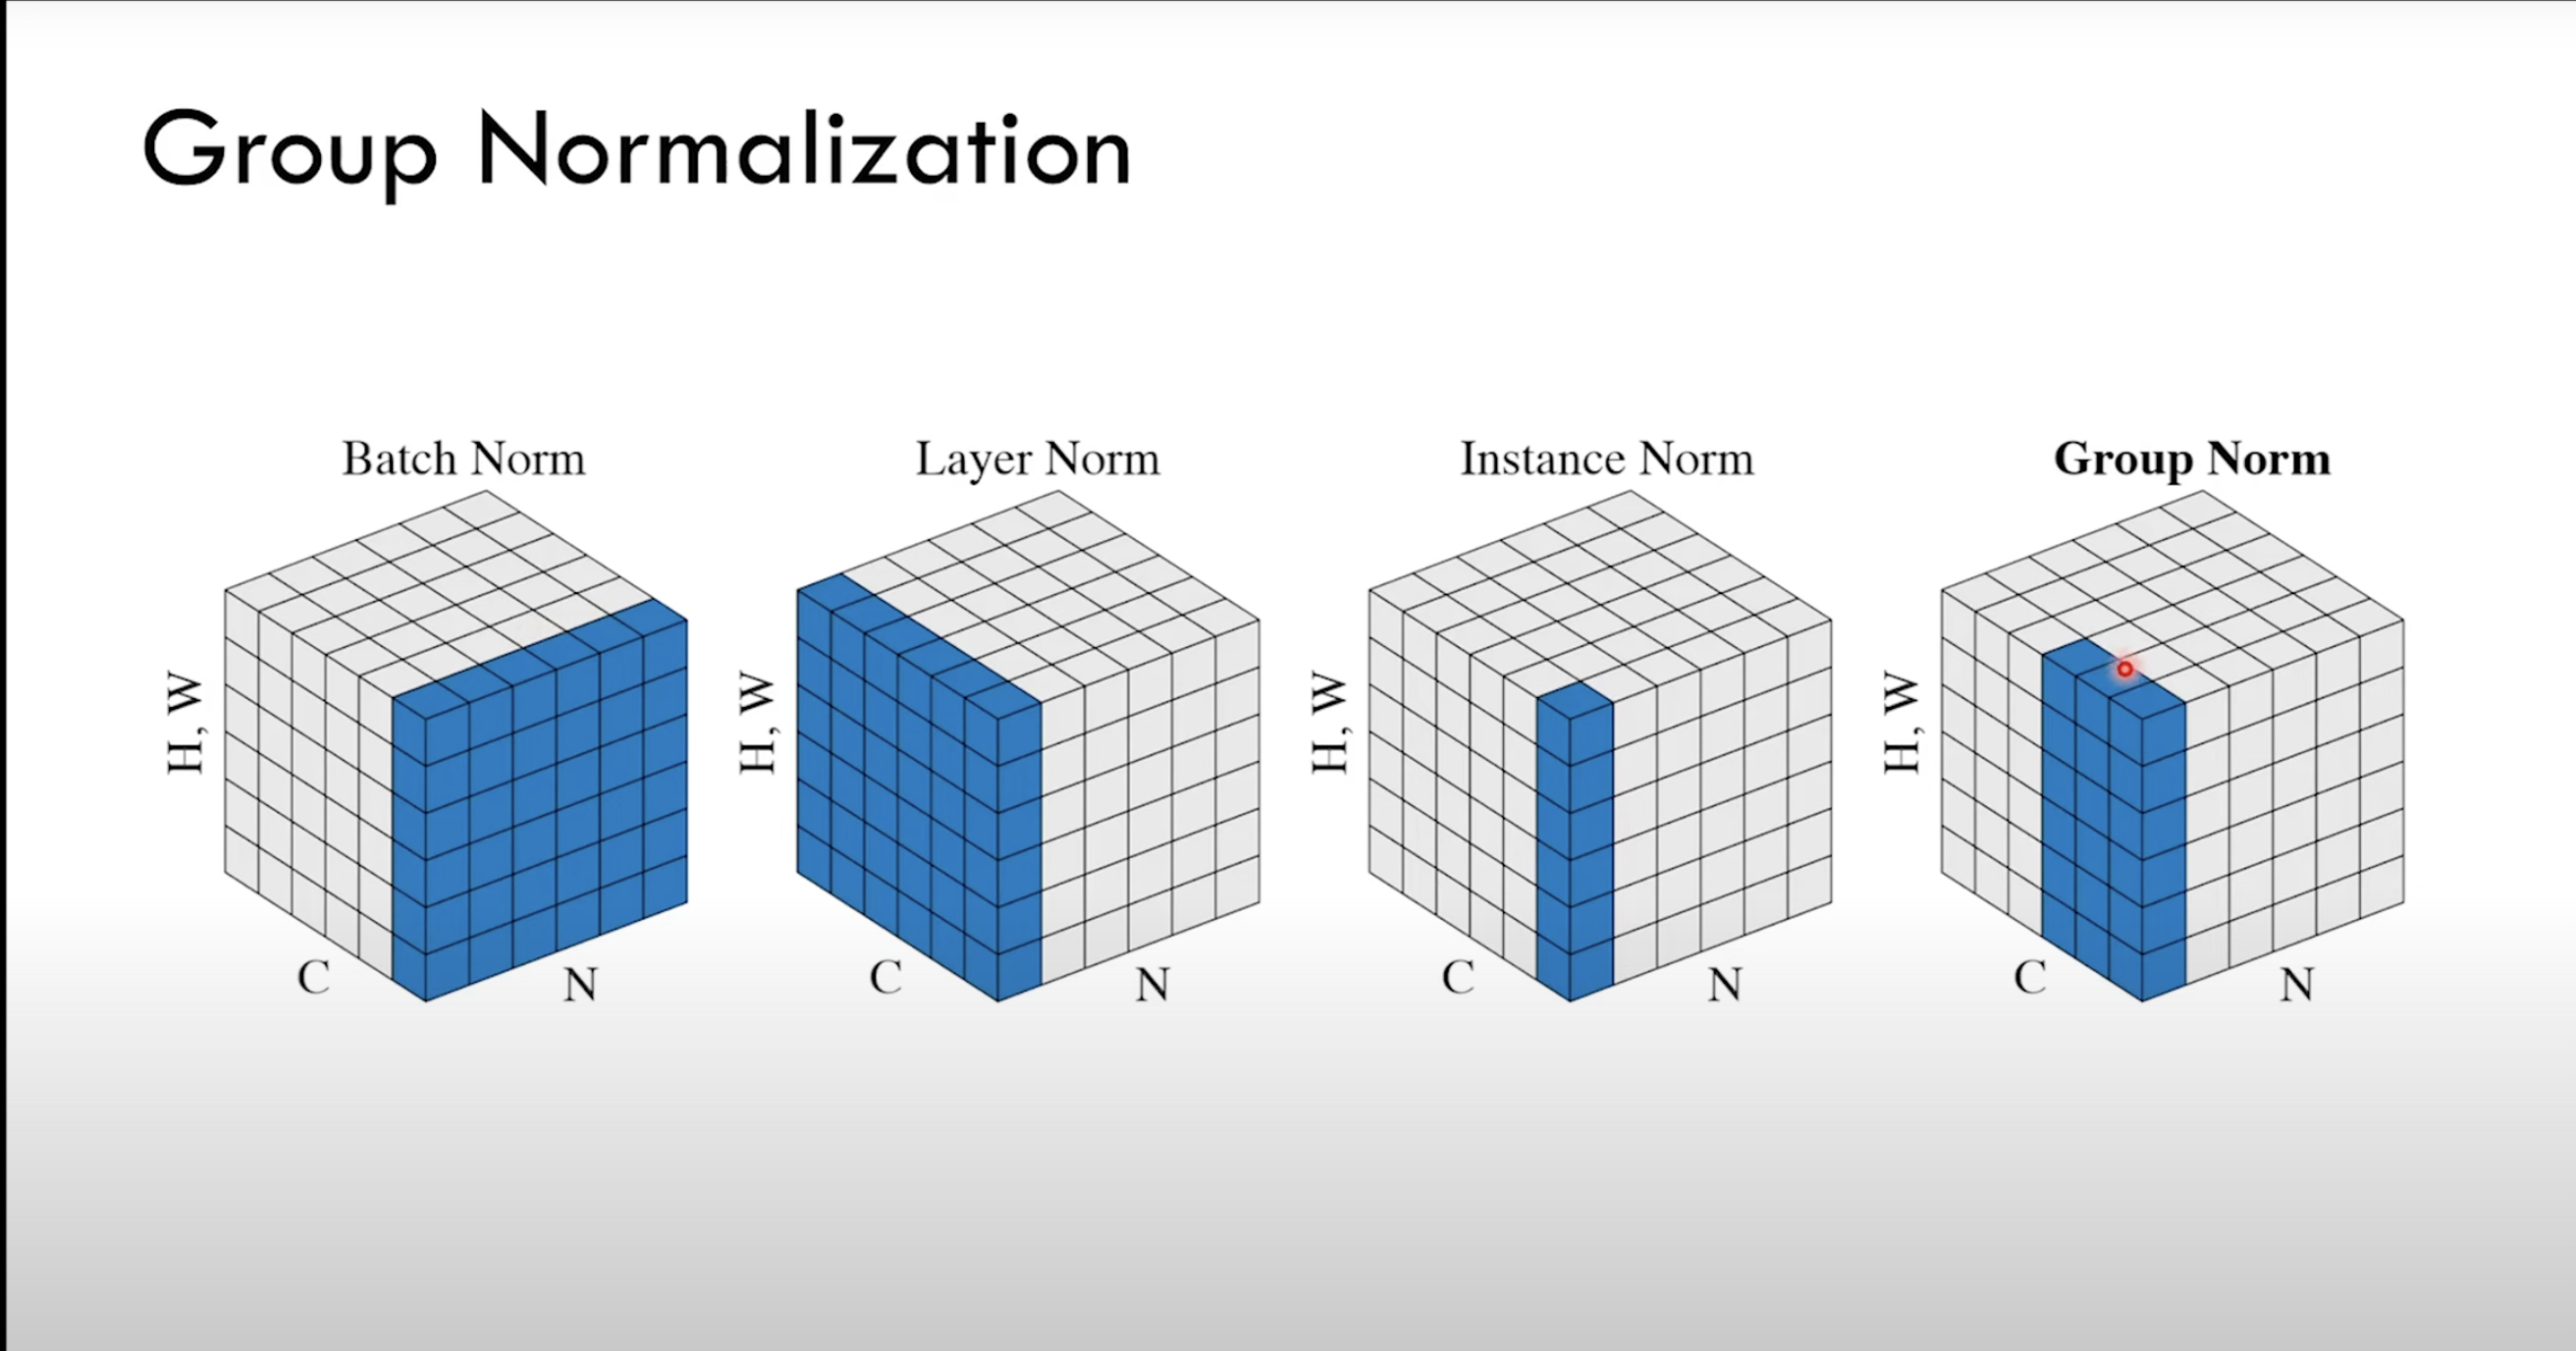

In [16]:
torch.manual_seed(12)
x = torch.rand(2,3,4,2)        
print(x)
n , c , h , w = x.shape
x = x.view(n , c , h*w)    
x = x.transpose(-1,-2)      #--> (n , c , h*w ) --> (n, h*w, c)

print(x)

tensor([[[[0.4657, 0.2328],
          [0.4527, 0.5871],
          [0.4086, 0.1272],
          [0.6373, 0.2421]],

         [[0.7312, 0.7224],
          [0.1992, 0.6948],
          [0.5830, 0.6318],
          [0.5559, 0.1262]],

         [[0.9790, 0.8443],
          [0.1256, 0.4456],
          [0.6601, 0.0554],
          [0.1573, 0.8137]]],


        [[[0.7216, 0.2717],
          [0.3003, 0.6099],
          [0.5784, 0.6083],
          [0.4339, 0.8813]],

         [[0.3216, 0.2604],
          [0.2566, 0.1872],
          [0.6423, 0.1786],
          [0.1435, 0.7490]],

         [[0.7275, 0.1641],
          [0.3273, 0.1239],
          [0.6138, 0.4535],
          [0.7659, 0.1800]]]])
tensor([[[0.4657, 0.7312, 0.9790],
         [0.2328, 0.7224, 0.8443],
         [0.4527, 0.1992, 0.1256],
         [0.5871, 0.6948, 0.4456],
         [0.4086, 0.5830, 0.6601],
         [0.1272, 0.6318, 0.0554],
         [0.6373, 0.5559, 0.1573],
         [0.2421, 0.1262, 0.8137]],

        [[0.7216, 0.3216, 0.727

In [ ]:
#decoder 

class VAE_Decoder(nn.Sequential):

    def __init__(self,x):

        super().__init__(
            nn.Conv2d(4, 4 , kernal_size=1 , padding = 0),        #(batch_size, channel , height , width) --> (batch_size , 128 , height , width) , padding = 1 
            nn.Conv2d(4 , 512 , kernal_size = 3 , padding = 1), 


            Vae_ResidualBlock(512, 512 ),
            Vae_AttentionBlock(512),
            Vae_ResidualBlock(512, 512),
            Vae_ResidualBlock(512, 512 ),   
            Vae_ResidualBlock(512, 512),   
            Vae_ResidualBlock(512, 512 ),


            nn.Upsample(scale_factor=2),



            nn.Conv2d(512, 512 , kernal_size=3 ,padding = 1),

            Vae_ResidualBlock(512, 512 ), 
            Vae_ResidualBlock(512, 512 ), 
            
            
            Vae_ResidualBlock(512, 512 ),

            nn.Conv2d(512, 512, kernal_size=3 , stride = 2, padding = 0),  
            Vae_ResidualBlock(512, 512 ),
            Vae_ResidualBlock(512, 512 ),
            Vae_ResidualBlock(512, 512 ),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 512, kernal_size=3 , padding = 1),

            Vae_ResidualBlock(512, 256 ),
            Vae_ResidualBlock(256, 256 ),
            Vae_ResidualBlock(256, 256 ),
            
            nn.Upsample(scale_factor=2),

            nn.Conv2d(256, 52562, kernal_size=3 , padding = 1),

            Vae_ResidualBlock(256 ,128),
            Vae_ResidualBlock(128, 128 ),
            Vae_ResidualBlock(128, 128 ),

            nn.GroupNorm(32, 128),      # divide 128 features in group of 32

            nn.SiLU(),

            nn.Conv2d(128 , 3 , kernel_size=3 , padding=1)

        )

    def forward(self , x):
            
            x /= 0.18215

            for module in self:
                 x= module(x)

            return x
            









            





        

        


            
   